In [1]:
import numpy as np, uproot as ur, awkward as ak, pandas as pd
import matplotlib.pyplot as plt
import os, sys
import pickle
from scipy.optimize import curve_fit

import mplhep as hep
plt.figure()
hep.style.use("CMS")
plt.close()

def gaus(x, amp, mean, sigma):
    return amp * np.exp( -(x - mean)**2 / (2*sigma**2) ) 

def phi_reconstruct(x, y, z):
    return np.degrees(np.arctan2(y, x))
    
def theta_reconstruct(x, y, z):
    return np.degrees(np.arccos(abs(z)/np.sqrt(x**2+y**2+z**2)))

def vector_angle_reconstruct(x, y, z):
    data = np.concatenate((np.array(x)[:, np.newaxis], 
                           np.array(y)[:, np.newaxis], 
                           np.array(z)[:, np.newaxis]), 
                          axis=1)
    datamean = data.mean(axis=0)
    centered_data = data - datamean

    _, _, vv = np.linalg.svd(centered_data)
    direction_vector = vv[0]
    if direction_vector[2] > 0:
        direction_vector *= -1
        
    x_vec, y_vec, z_vec = direction_vector
    
    theta = theta_reconstruct(x_vec, y_vec, z_vec)
    phi = phi_reconstruct(x_vec, y_vec, z_vec)
    
    return theta, phi
    

In [2]:
with ur.open("/home/jiajun/muography/data/planar/planar_free_0.edm4hep.root:events") as f:
    arrays = f.arrays()

In [3]:
data_cell_cut = ak.num(arrays[f'MuographyHits.energy'], axis=1) == 2

In [4]:
x = arrays[f'MuographyHits.position.x'][data_cell_cut]
y = arrays[f'MuographyHits.position.y'][data_cell_cut]
z = arrays[f'MuographyHits.position.z'][data_cell_cut]
status = arrays["MCParticles.generatorStatus"]
mc_px = arrays["MCParticles.momentum.x"][status==1][data_cell_cut]
mc_py = arrays["MCParticles.momentum.y"][status==1][data_cell_cut]
mc_pz = arrays["MCParticles.momentum.z"][status==1][data_cell_cut]
mc_x = arrays["MCParticles.vertex.x"][status==1][data_cell_cut]
mc_y = arrays["MCParticles.vertex.y"][status==1][data_cell_cut]
mc_z = arrays["MCParticles.vertex.z"][status==1][data_cell_cut]
mc_theta = theta_reconstruct(mc_px,mc_py,mc_pz)
mc_phi = phi_reconstruct(mc_px,mc_py,mc_pz)

In [5]:
layer_cut = z[:,0]!=z[:,1]

In [6]:
theta0 = []
phi0 = []

theta1 = []
phi1 = []

theta2 = []
phi2 = []

for evt in range(len(x)):# hits for ONE event
    #gpt method
    pts = np.column_stack((
        ak.to_numpy(x[evt]),
        ak.to_numpy(y[evt]),
        ak.to_numpy(z[evt])
    ))
    
    # center
    centroid = pts.mean(axis=0)
    pts_c = pts - centroid
    
    # PCA
    cov = np.cov(pts_c, rowvar=False)
    eigvals, eigvecs = np.linalg.eigh(cov)
    direction = eigvecs[:, np.argmax(eigvals)]
    
    # normalize
    direction /= np.linalg.norm(direction)
    
    # angles
    vx, vy, vz = direction
    theta1.append(np.degrees(np.arccos(abs(vz))))
    phi1.append(np.degrees(np.arctan2(vy, vx)))

    
    ############################
    # Old reco method
    theta, phi = vector_angle_reconstruct(x[evt],y[evt],z[evt])
    theta0.append(theta)
    phi0.append(phi)

    
    ###########################
    # 2 hits method by hand
    dx = x[evt][0] - x[evt][1]
    dy = y[evt][0] - y[evt][1]
    dz = z[evt][0] - z[evt][1]
    r = np.sqrt(dx**2 + dy**2 + dz**2)
    theta2.append(np.degrees(np.arccos(abs(dz) / r)))
    phi2.append(np.degrees(np.arctan2(dy, dx)))

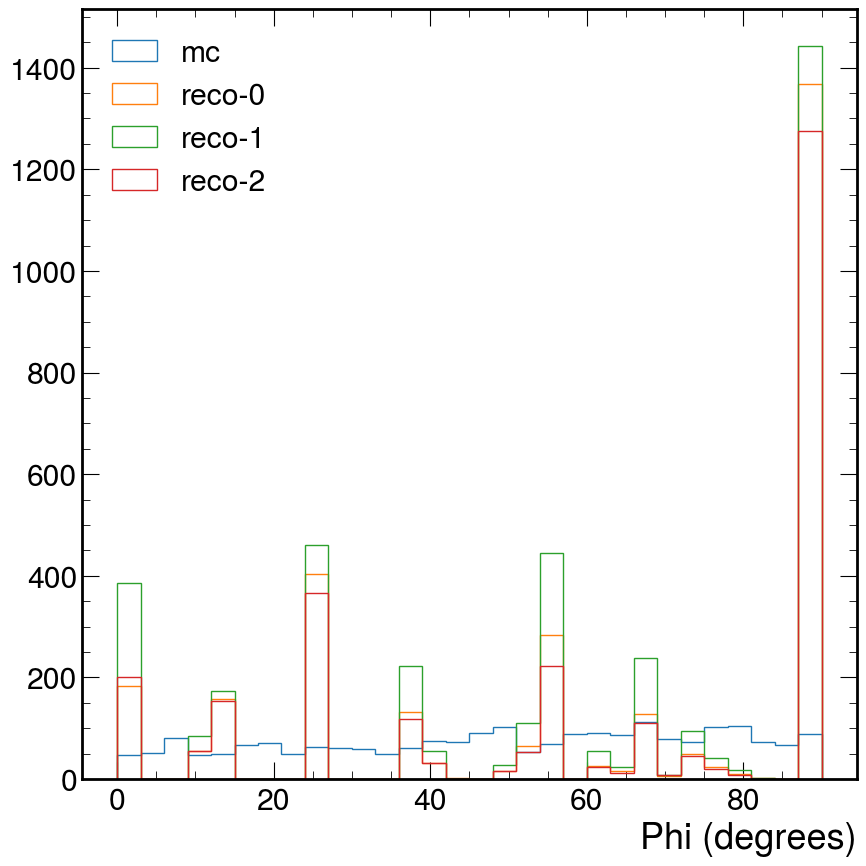

In [10]:
plt.hist(np.concatenate(mc_phi),histtype='step',label='mc',bins=30,range=(0,90))
plt.hist(np.array(phi0),histtype='step',label='reco-0',bins=30,range=(0,90))
plt.hist(np.array(phi1),histtype='step',label='reco-1',bins=30,range=(0,90))
plt.hist(np.array(phi2),histtype='step',label='reco-2',bins=30,range=(0,90))

plt.xlabel('Phi (degrees)')
plt.legend()

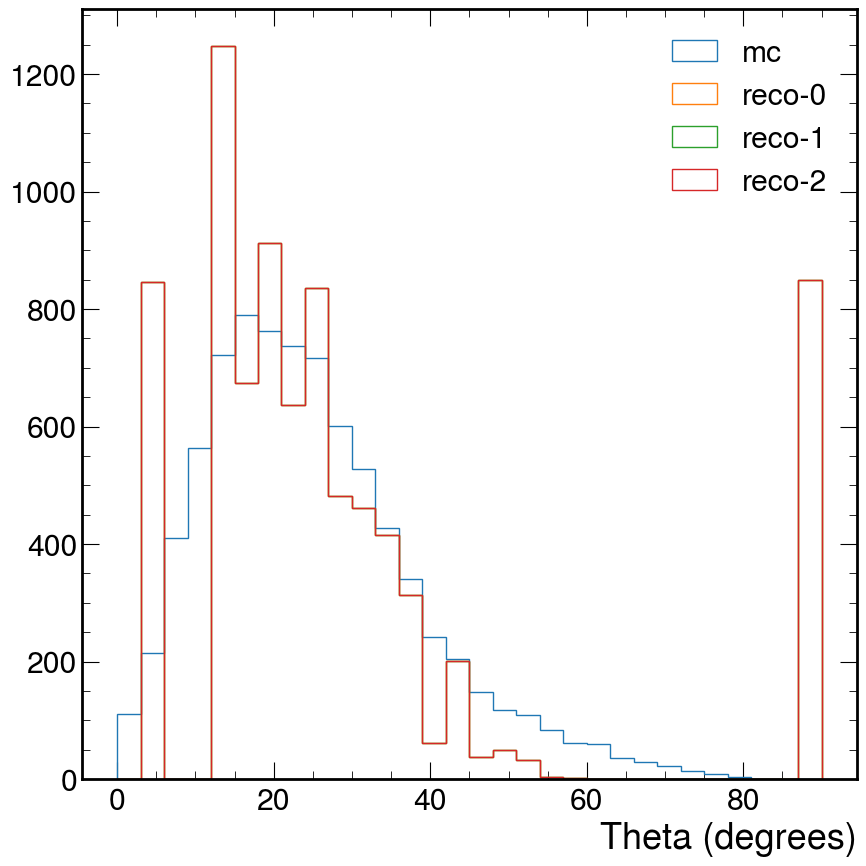

In [7]:
plt.hist(np.concatenate(mc_theta),histtype='step',label='mc',bins=30,range=(0,90))
plt.hist(np.array(theta0),histtype='step',label='reco-0',bins=30,range=(0,90))
plt.hist(np.array(theta1),histtype='step',label='reco-1',bins=30,range=(0,90))
plt.hist(np.array(theta2),histtype='step',label='reco-2',bins=30,range=(0,90))

plt.xlabel('Theta (degrees)')
plt.legend()

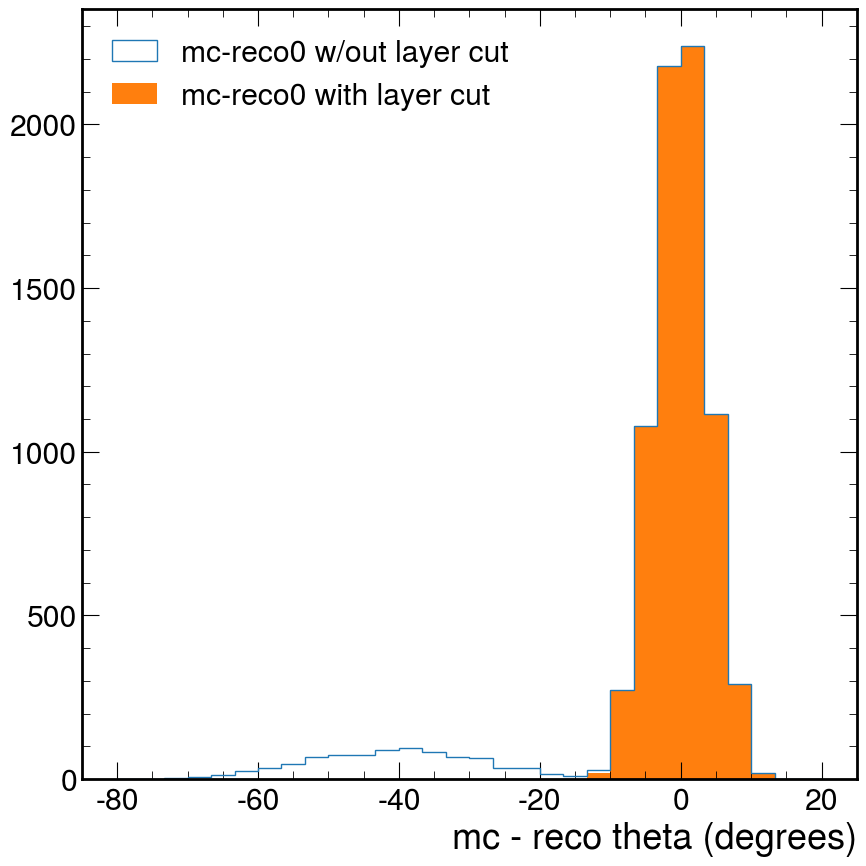

In [8]:
plt.hist(np.concatenate(mc_theta)-np.array(theta0),histtype='step',label='mc-reco0 w/out layer cut',bins=30,range=(-80,20))

plt.hist(np.concatenate(mc_theta[layer_cut])-np.array(theta0)[layer_cut],label='mc-reco0 with layer cut',bins=30,range=(-80,20))

# plt.hist(np.concatenate(mc_theta[layer_cut])-np.array(theta1),histtype='step',label='mc-reco1',bins=30)
# plt.hist(np.concatenate(mc_theta[layer_cut])-np.array(theta2),histtype='step',label='mc-reco2',bins=30)

plt.xlabel('mc - reco theta (degrees)')
plt.legend()

Text(0.5, 0.98, 'With Layer Cut')

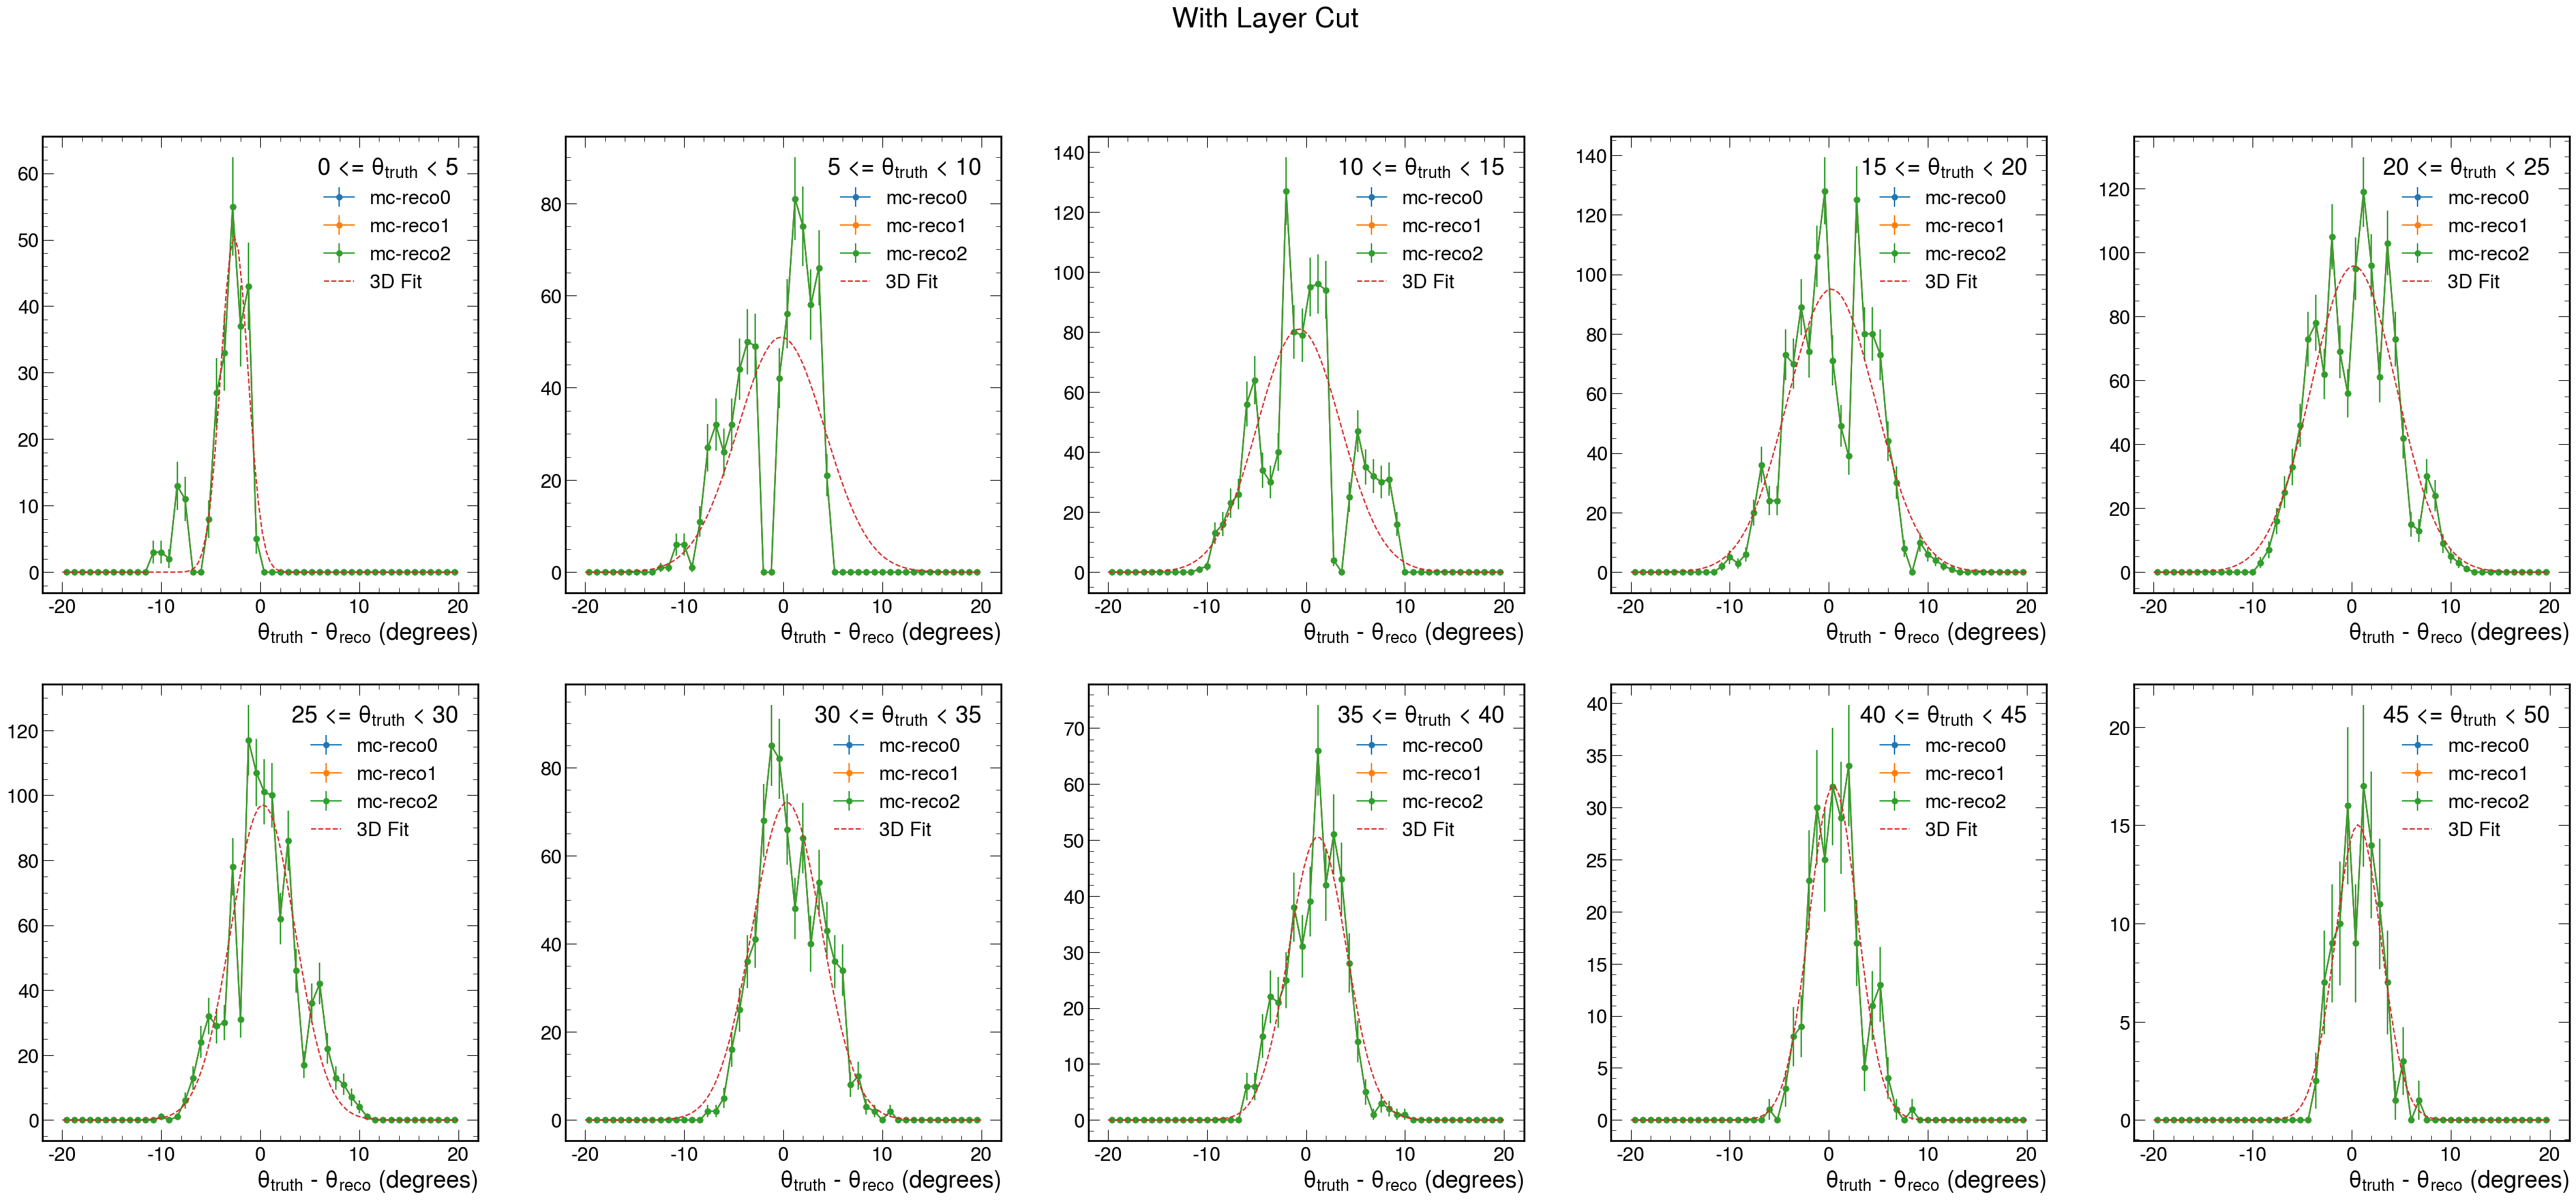

In [84]:
bins_t = []
fits = []
error = []

res = 5
width = 20
bin_num = 50
fig, ax = plt.subplots(2,5,figsize=(50,20))
for i in range(10):
    plt.sca(ax[i//5,i%5])
    cut = (((i) * res <= np.array(mc_theta[layer_cut])) & (np.array(mc_theta[layer_cut]) < (i+1) * res))[:,0]
    ys,xs = np.histogram(np.concatenate(mc_theta[layer_cut])[cut]-np.array(theta0)[layer_cut][cut],bins=bin_num,range=(-width,width))
    bc=(xs[1:]+xs[:-1])/2
    plt.errorbar(bc,ys,yerr=np.sqrt(ys), fmt='-o',label='mc-reco0')
    
    ys,xs = np.histogram(np.concatenate(mc_theta[layer_cut])[cut]-np.array(theta1)[layer_cut][cut],bins=bin_num,range=(-width,width))
    bc=(xs[1:]+xs[:-1])/2
    plt.errorbar(bc,ys,yerr=np.sqrt(ys), fmt='-o',label='mc-reco1')

    ys,xs = np.histogram(np.concatenate(mc_theta[layer_cut])[cut]-np.array(theta2)[layer_cut][cut],bins=bin_num,range=(-width,width))
    bc=(xs[1:]+xs[:-1])/2
    plt.errorbar(bc,ys,yerr=np.sqrt(ys), fmt='-o',label='mc-reco2')

    bins_t.append((res)*(1.5+i))
    try:
        coeff, covar = curve_fit(gaus,np.array(bc),np.array(ys),p0=(100,0.1,10))
        fits.append(coeff)
        error.append(covar[2][2])
        x=np.linspace(-width,width,100)
        plt.errorbar(x,gaus(x,*coeff),fmt='--',label='3D Fit')
    except: 
        fits.append([0,0,0])
        error.append(0)
            
    plt.xlabel(rf'$\theta_{{truth}}$ - $\theta_{{reco}}$ (degrees)')
    plt.legend(title=rf'{i*res} <= $\theta_{{truth}}$ < {(i+1)*res}',loc='upper right')
plt.suptitle('With Layer Cut')

Text(0.5, 1.0, 'Planar Detector, 5 cm tile, 64 channels')

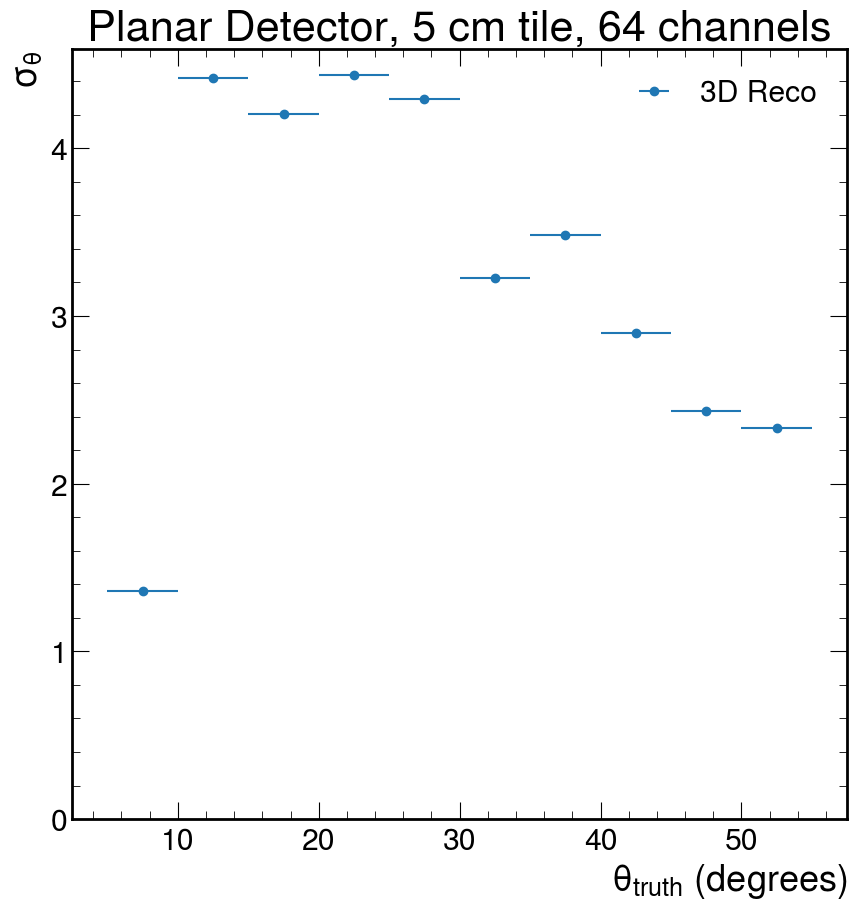

In [87]:

plt.errorbar(bins_t,abs(np.array(fits)[:,2]),xerr=(bins_t[1]-bins_t[0])/2,label=f'3D Reco',fmt='o')
plt.ylabel(r'$\sigma_{\theta}$')
plt.ylim(bottom=0)
plt.xlabel(r'$\theta_{{truth}}$ (degrees)')

plt.legend()
plt.title('Planar Detector, 5 cm tile, 64 channels')

Text(0.5, 0.98, 'With Layer Cut')

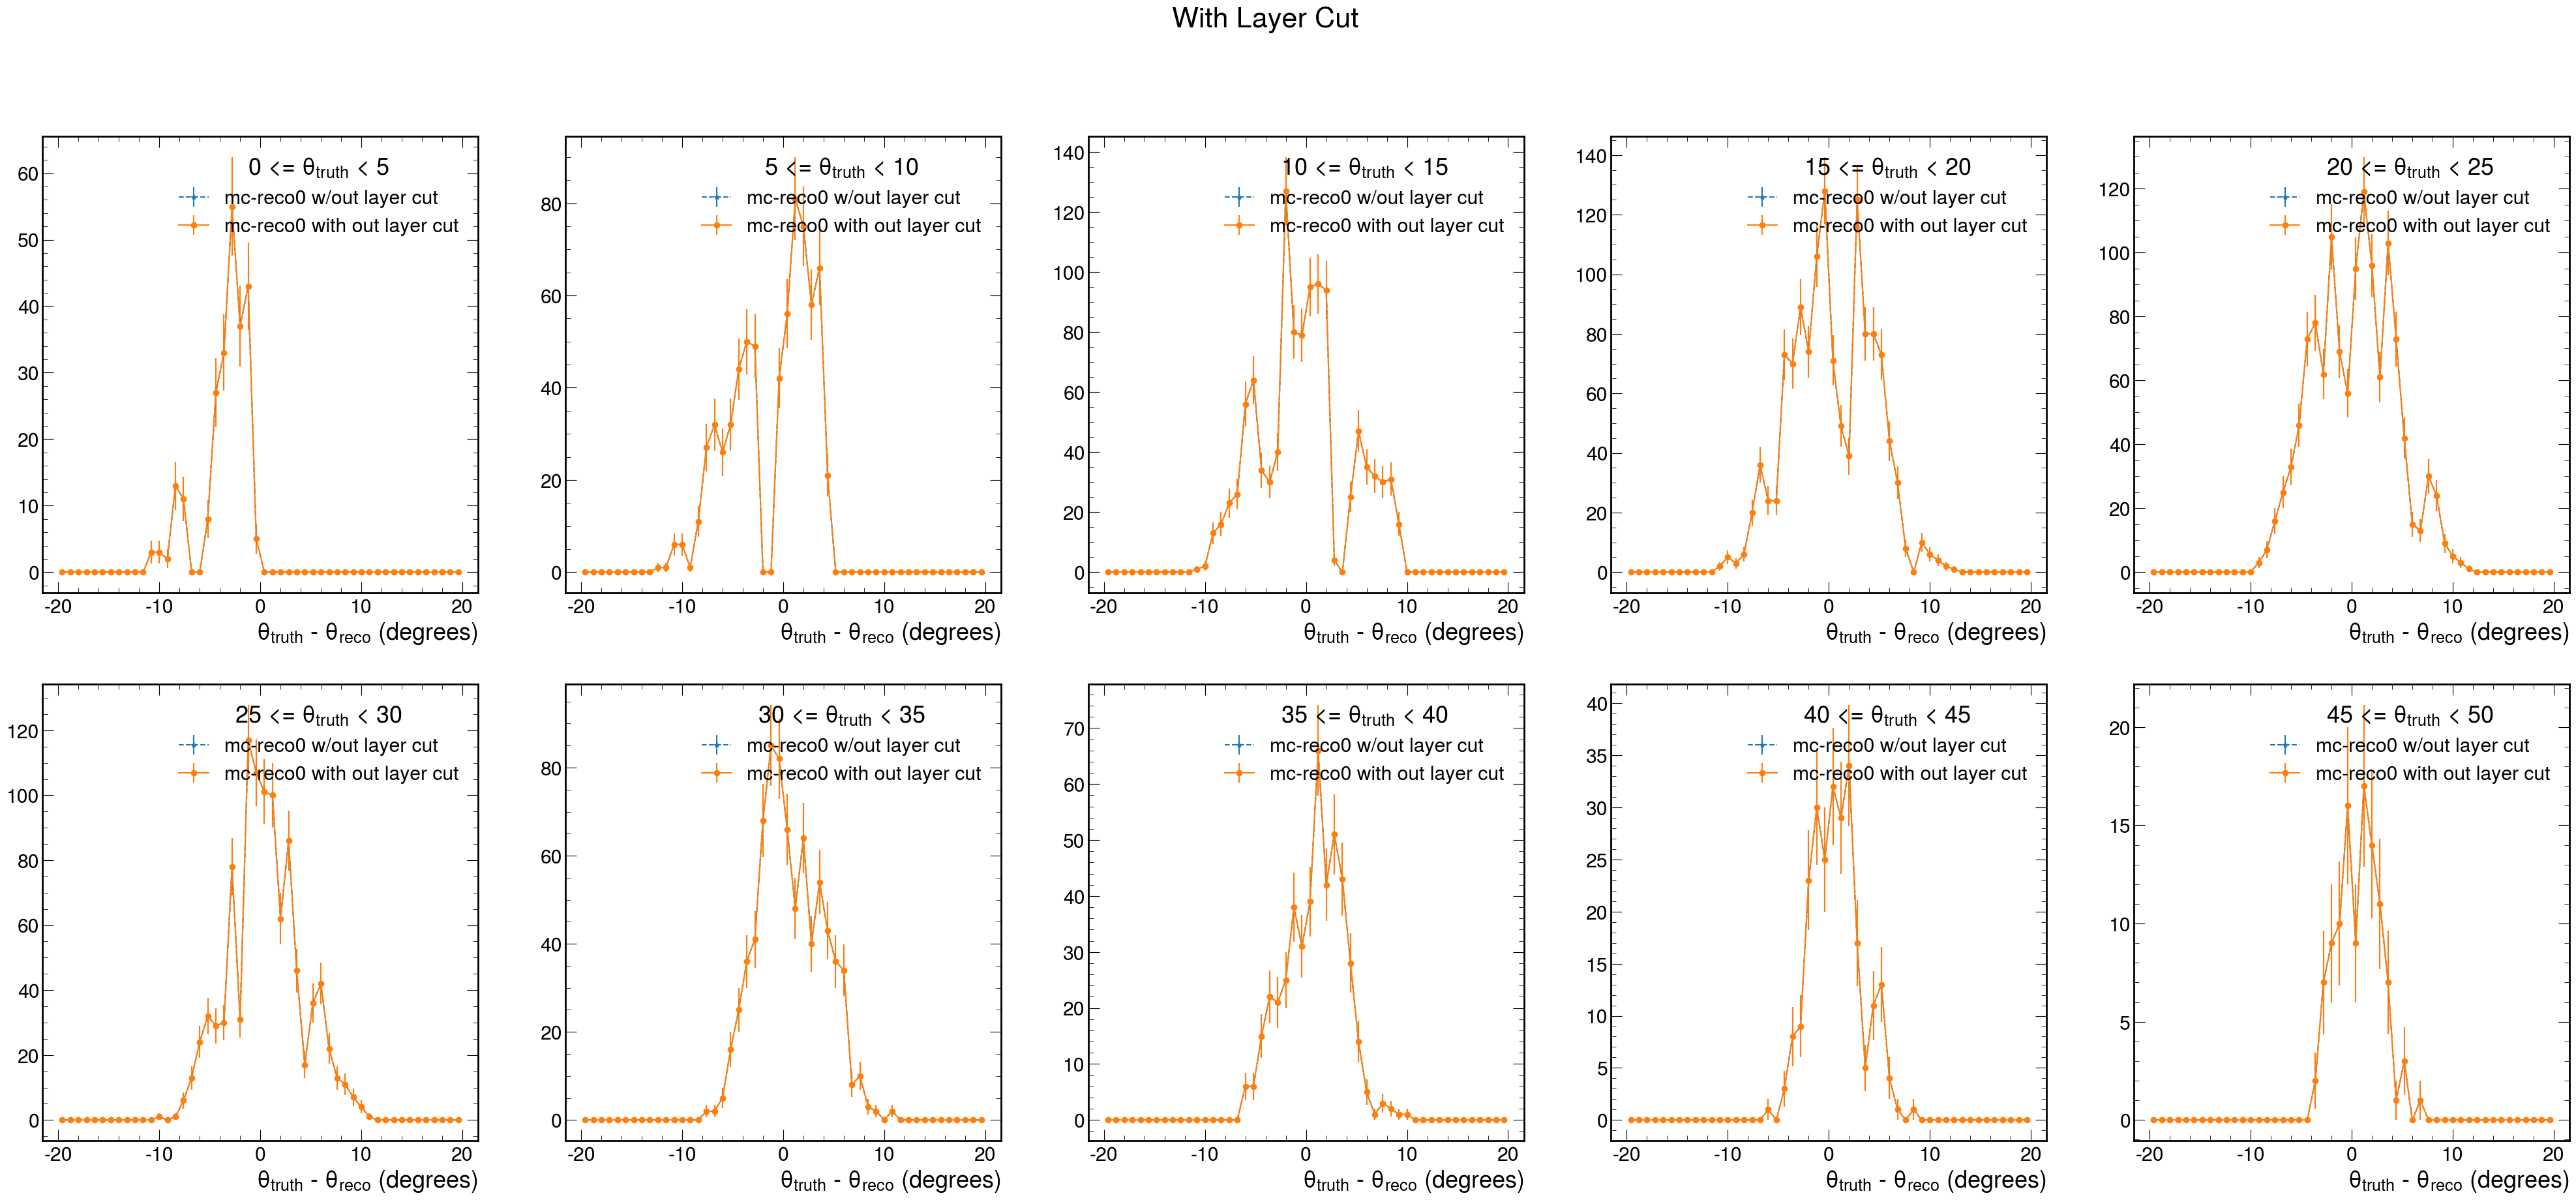

In [65]:
bins_t = []
res_x = []
err_x = []

res = 5
width = 20
bin_num = 50
fig, ax = plt.subplots(2,5,figsize=(50,20))
for i in range(10):
    plt.sca(ax[i//5,i%5])
    cut = (((i) * res <= np.array(mc_theta)) & (np.array(mc_theta) < (i+1) * res))[:,0]
    ys,xs = np.histogram(np.concatenate(mc_theta)[cut]-np.array(theta0)[cut],bins=bin_num,range=(-width,width))
    bc=(xs[1:]+xs[:-1])/2
    plt.errorbar(bc,ys,yerr=np.sqrt(ys), fmt='--*',label='mc-reco0 w/out layer cut')

    cut = (((i) * res <= np.array(mc_theta[layer_cut])) & (np.array(mc_theta[layer_cut]) < (i+1) * res))[:,0]
    ys,xs = np.histogram(np.concatenate(mc_theta[layer_cut])[cut]-np.array(theta0)[layer_cut][cut],bins=bin_num,range=(-width,width))
    bc=(xs[1:]+xs[:-1])/2
    plt.errorbar(bc,ys,yerr=np.sqrt(ys), fmt='-o',label='mc-reco0 with out layer cut')
    plt.xlabel(rf'$\theta_{{truth}}$ - $\theta_{{reco}}$ (degrees)')
    plt.legend(title=rf'{i*res} <= $\theta_{{truth}}$ < {(i+1)*res}',loc='upper right')
plt.suptitle('With Layer Cut')

Text(0.5, 0.98, 'With Layer Cut')

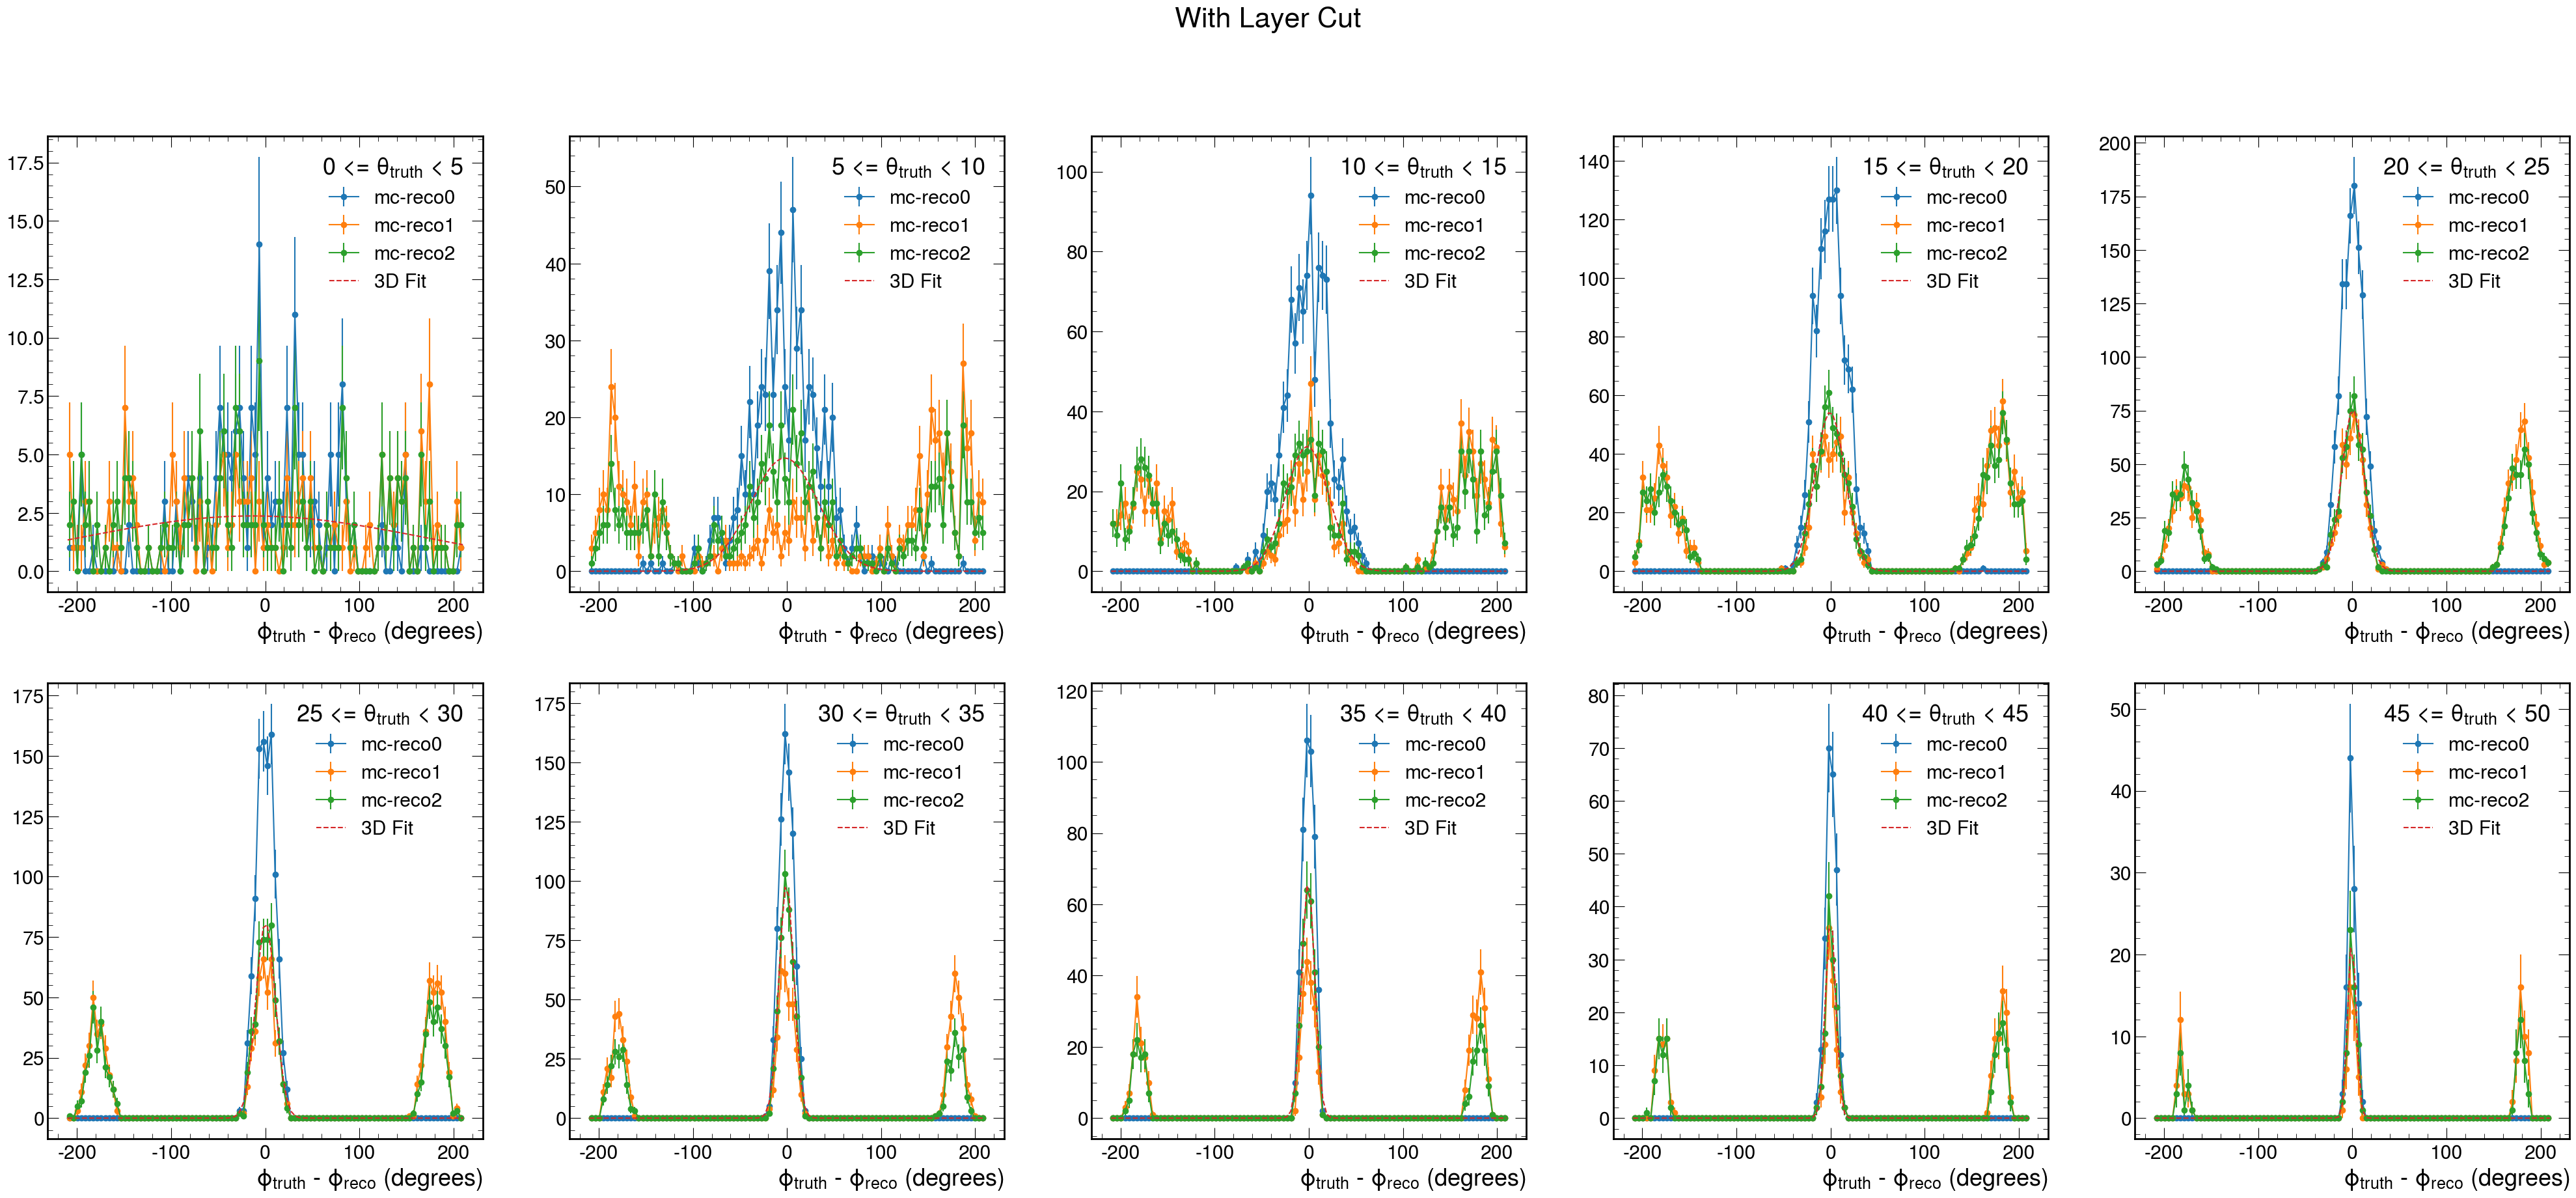

In [17]:
bins_t = []
fits = []
error = []

res = 5
width = 210
bin_num = 100
fig, ax = plt.subplots(2,5,figsize=(50,20))
for i in range(10):
    plt.sca(ax[i//5,i%5])
    cut = (((i) * res <= np.array(mc_theta[layer_cut])) & (np.array(mc_theta[layer_cut]) < (i+1) * res))[:,0]
    ys,xs = np.histogram(np.concatenate(mc_phi[layer_cut])[cut]-np.array(phi0)[layer_cut][cut],bins=bin_num,range=(-width,width))
    bc=(xs[1:]+xs[:-1])/2
    plt.errorbar(bc,ys,yerr=np.sqrt(ys), fmt='-o',label='mc-reco0')
    
    ys,xs = np.histogram(np.concatenate(mc_phi[layer_cut])[cut]-np.array(phi1)[layer_cut][cut],bins=bin_num,range=(-width,width))
    bc=(xs[1:]+xs[:-1])/2
    plt.errorbar(bc,ys,yerr=np.sqrt(ys), fmt='-o',label='mc-reco1')

    ys,xs = np.histogram(np.concatenate(mc_phi[layer_cut])[cut]-np.array(phi2)[layer_cut][cut],bins=bin_num,range=(-width,width))
    bc=(xs[1:]+xs[:-1])/2
    plt.errorbar(bc,ys,yerr=np.sqrt(ys), fmt='-o',label='mc-reco2')

    bins_t.append((res)*(1.5+i))
    try:
        coeff, covar = curve_fit(gaus,np.array(bc),np.array(ys),p0=(100,0.1,10))
        fits.append(coeff)
        error.append(covar[2][2])
        x=np.linspace(-width,width,100)
        plt.errorbar(x,gaus(x,*coeff),fmt='--',label='3D Fit')
    except: 
        fits.append([0,0,0])
        error.append(0)
            
    plt.xlabel(rf'$\phi_{{truth}}$ - $\phi_{{reco}}$ (degrees)')
    plt.legend(title=rf'{i*res} <= $\theta_{{truth}}$ < {(i+1)*res}',loc='upper right')
plt.suptitle('With Layer Cut')

In [54]:
def project_xy(x0, y0, z0, theta_deg, phi_deg, z1=750):
    # Convert degrees to radians
    theta = np.radians(theta_deg)
    phi = np.radians(phi_deg)

    dz = z1 - z0
    x1 = x0 + dz * np.tan(theta) * np.cos(phi)
    y1 = y0 + dz * np.tan(theta) * np.sin(phi)
    
    return x1, y1

In [ ]:
t = dz / vz

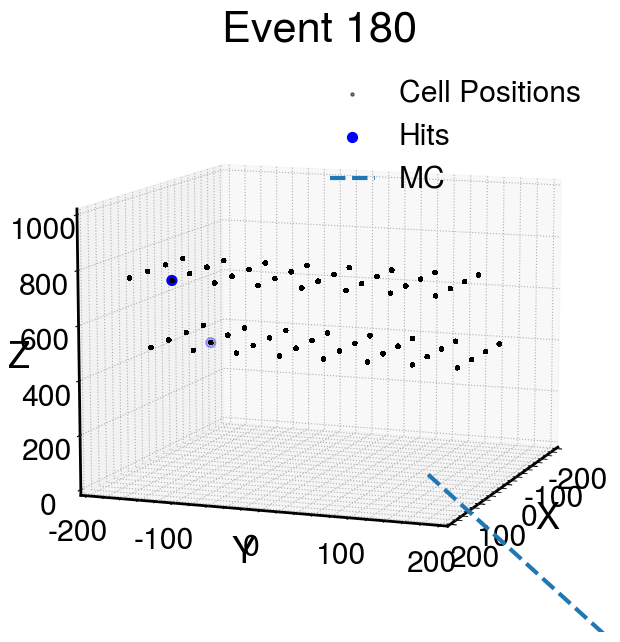

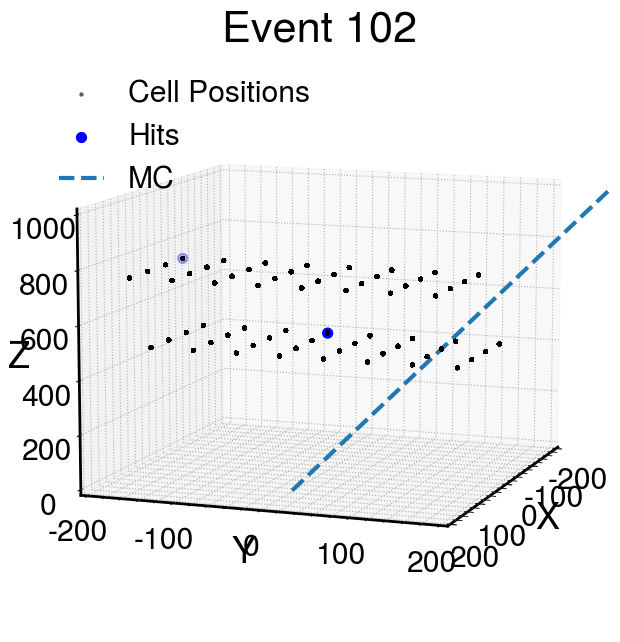

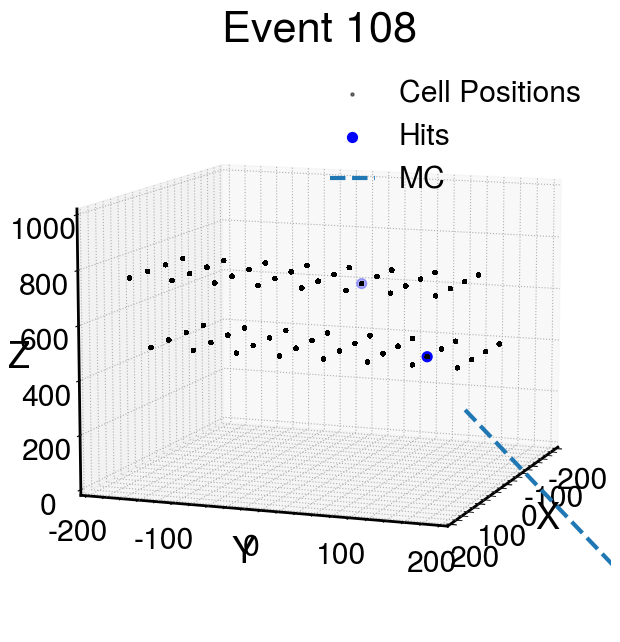

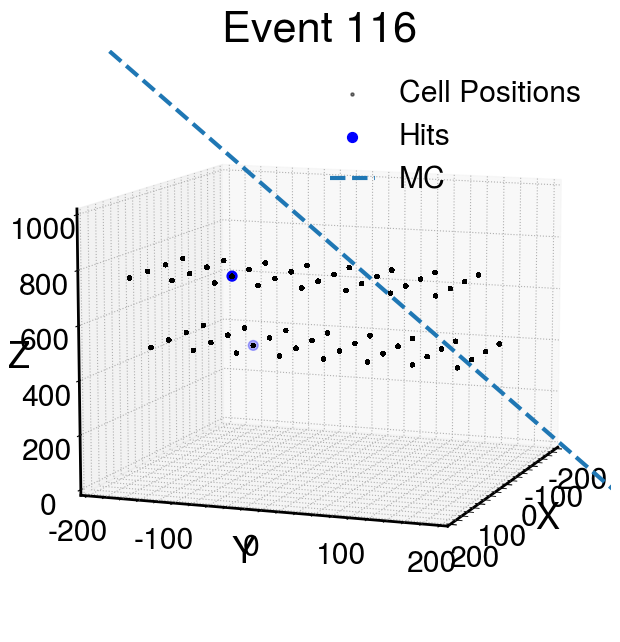

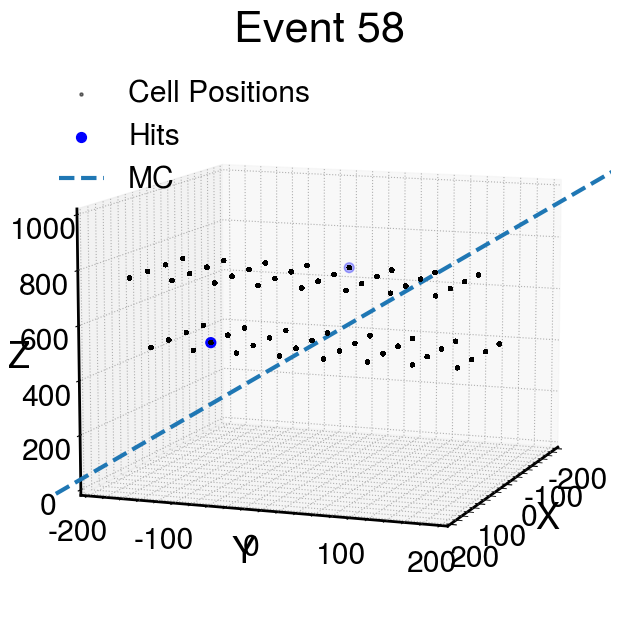

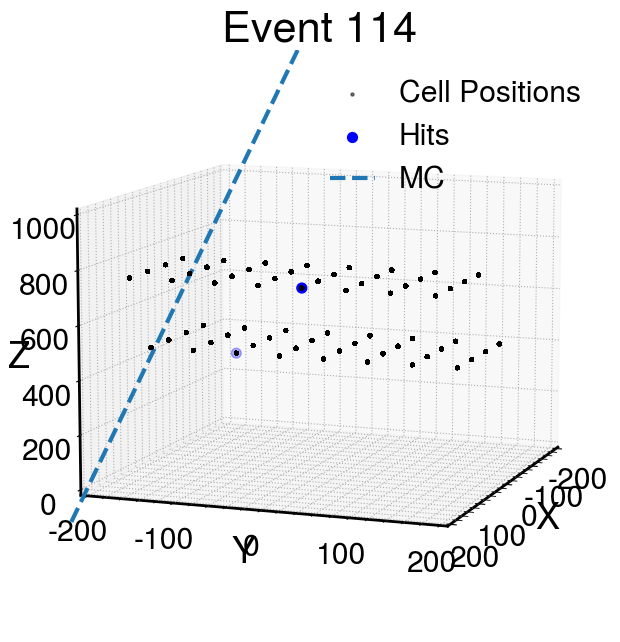

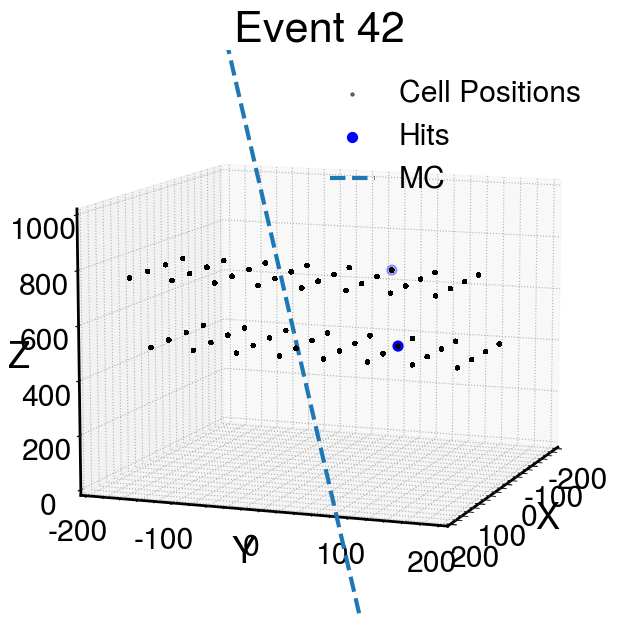

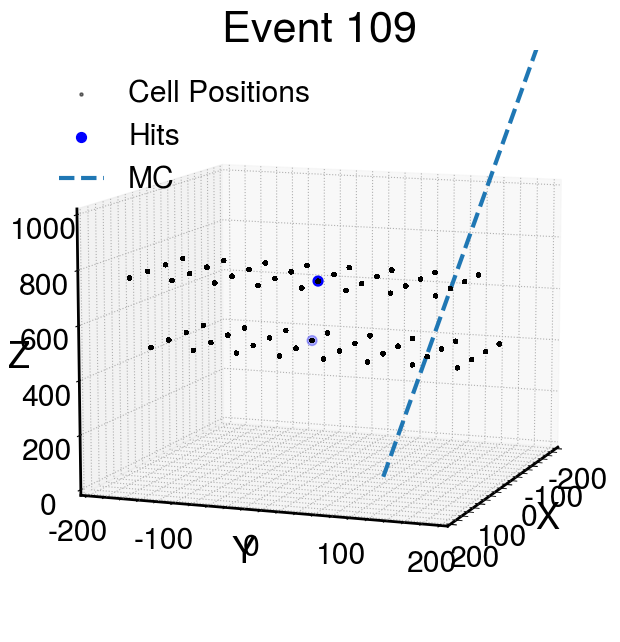

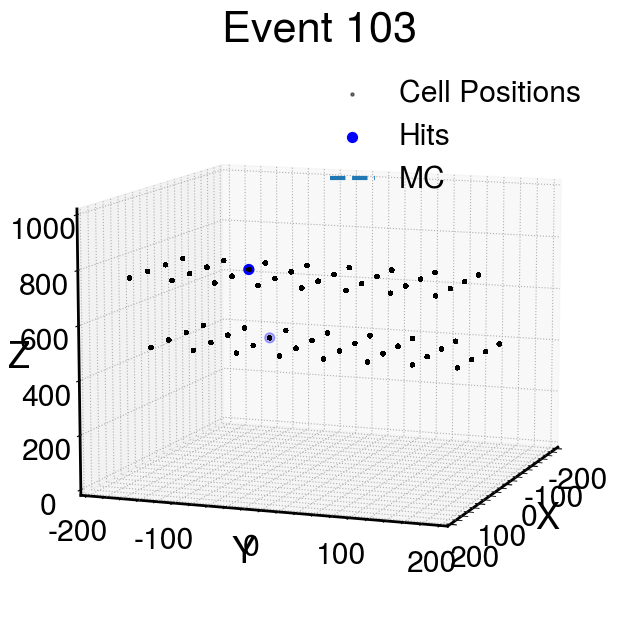

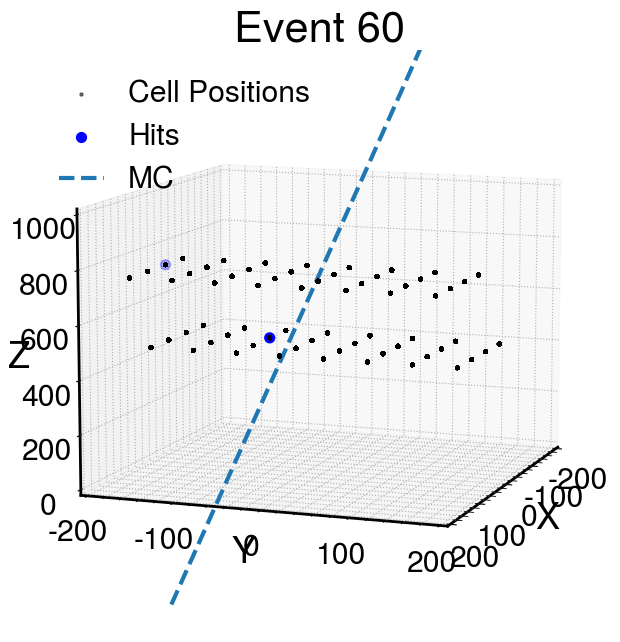

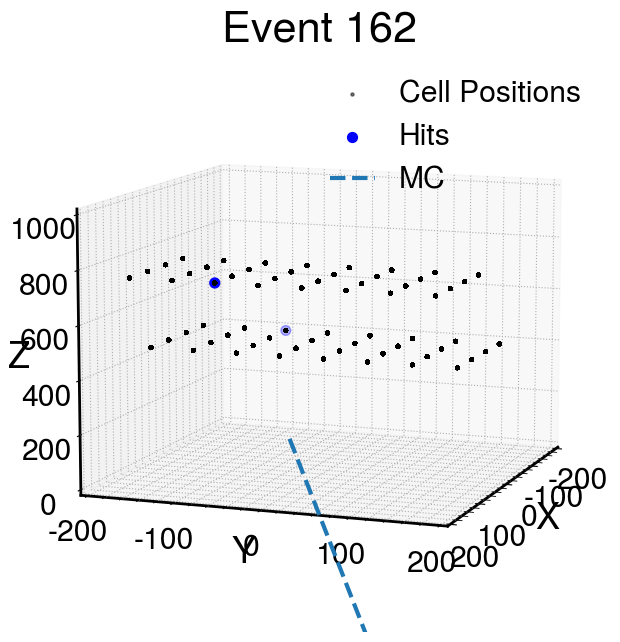

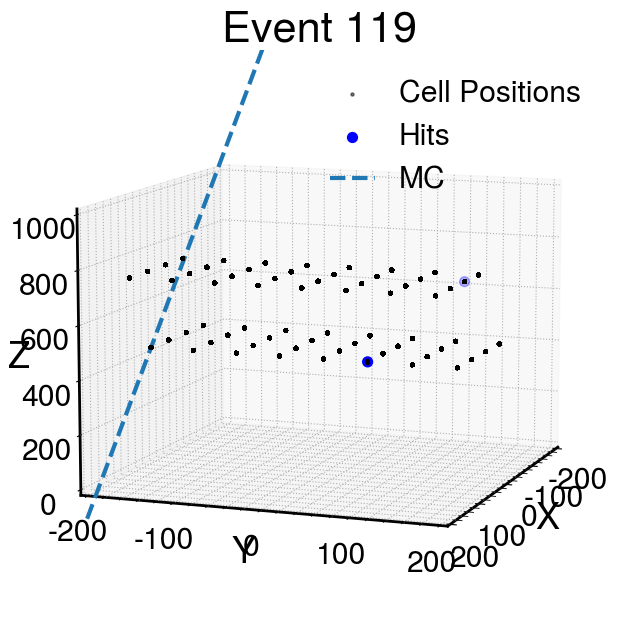

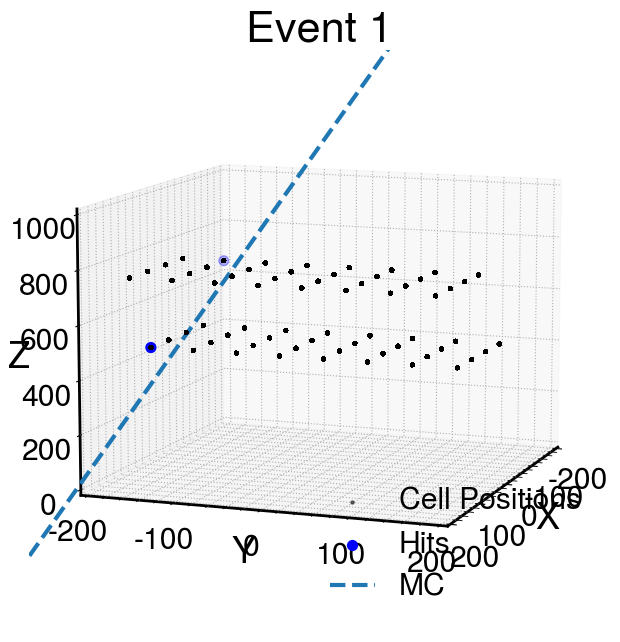

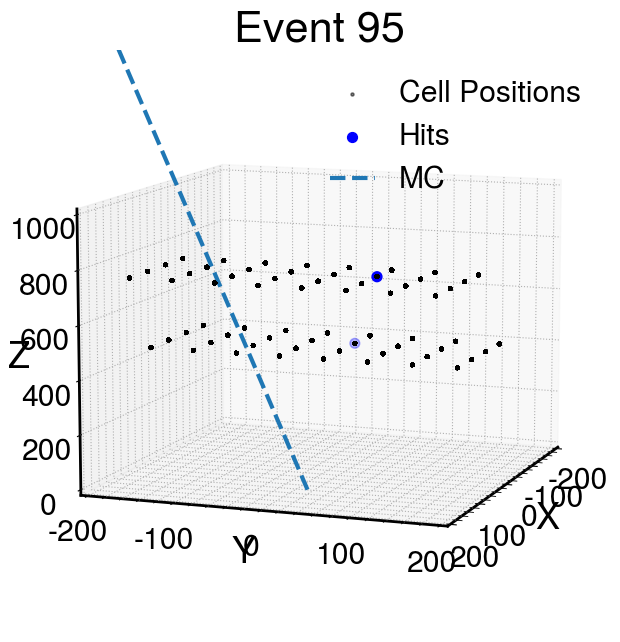

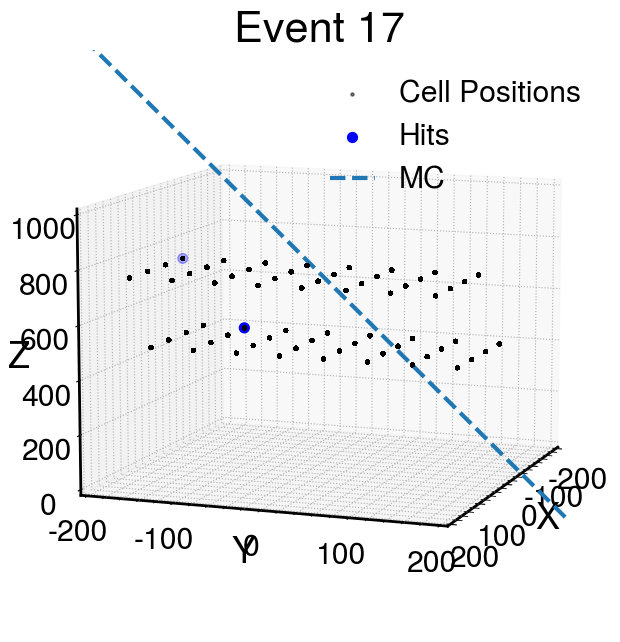

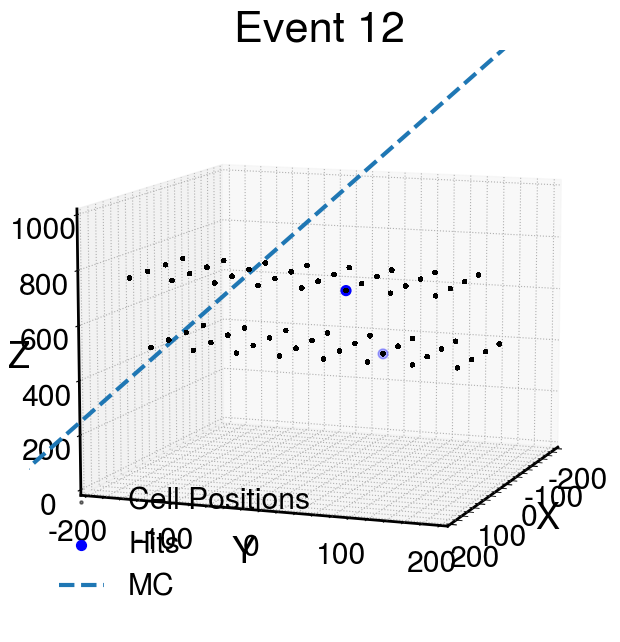

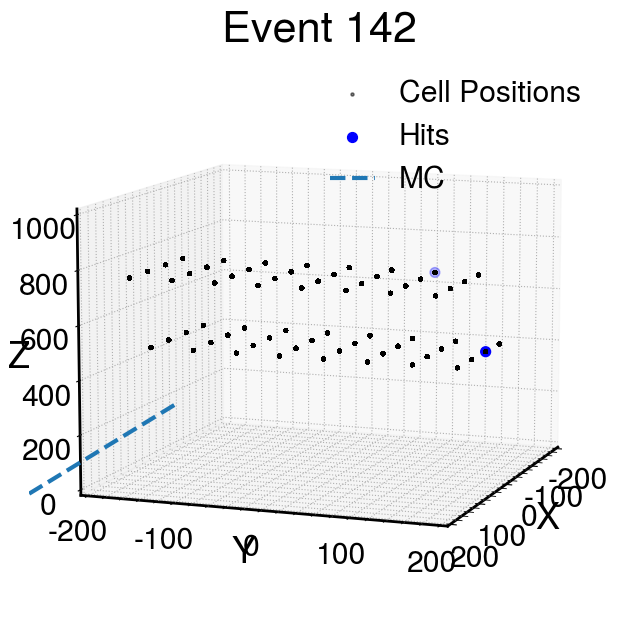

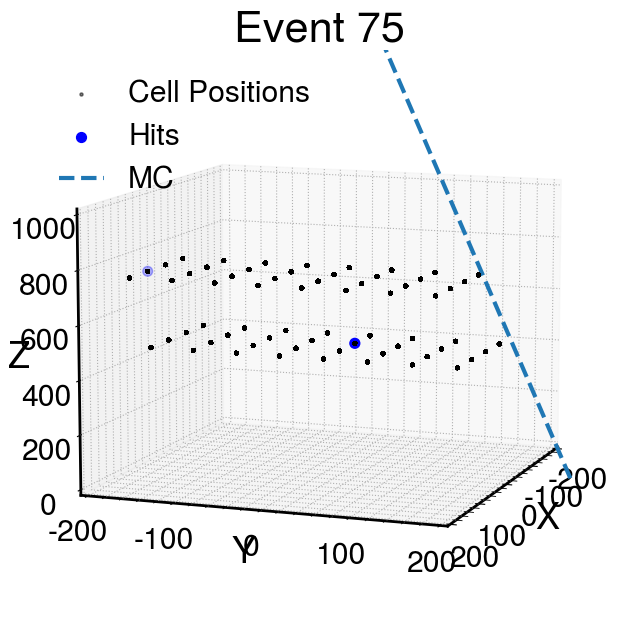

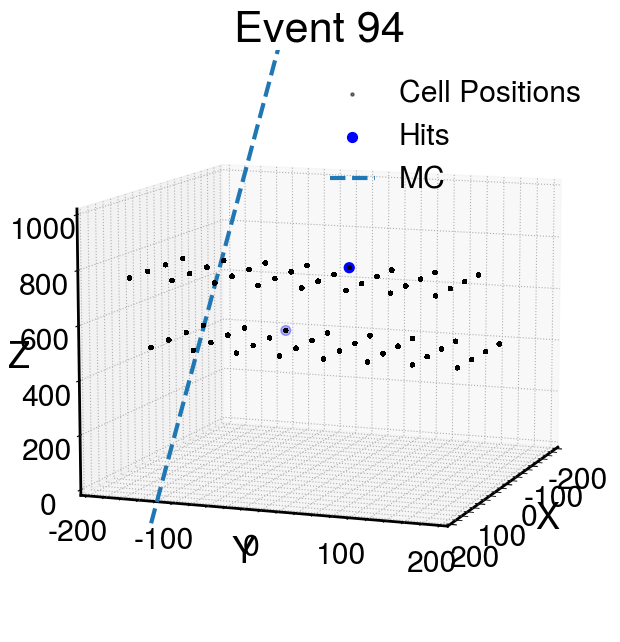

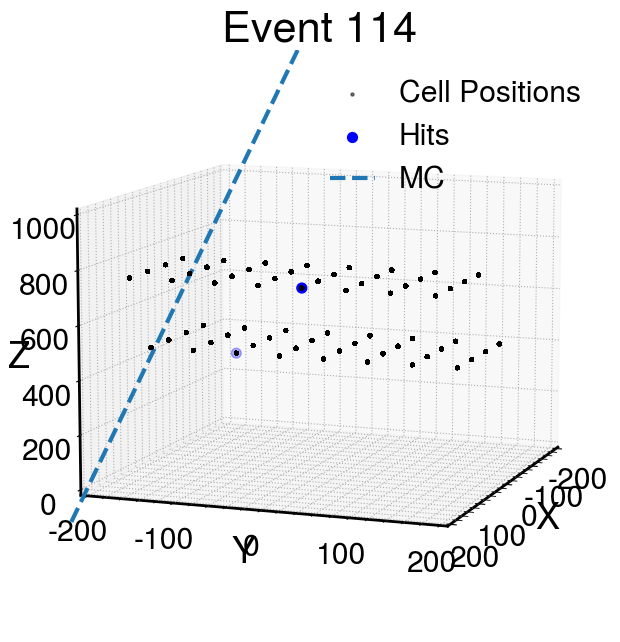

In [64]:
import matplotlib.pyplot as plt
import random

from mpl_toolkits.mplot3d import Axes3D

condition = layer_cut
for i in range(20):
# choose one event index
    evt = random.randint(1, 200) 
    
    # hit points (2 per event assumed)
    x_evt = x[condition][evt]
    y_evt = y[condition][evt]
    z_evt = z[condition][evt]
    
    fig = plt.figure(figsize=(8, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    # plot hit points
    ax.scatter(np.concatenate(x),np.concatenate(y),np.concatenate(z),c='black',s=5,alpha=0.5,label='Cell Positions')
    ax.scatter(x_evt, y_evt, z_evt, color='blue', s=50, label='Hits')


    mc_xxx, mc_yyy = project_xy(mc_x[evt][0],mc_y[evt][0],mc_z[evt][0],mc_theta[evt][0],mc_phi[evt][0],z1=0)
    ax.plot(
        [mc_xxx, mc_x[evt][0]],
        [mc_yyy, mc_y[evt][0]],
        zs=[0, mc_z[evt][0]],
        linestyle='--',
        linewidth=3,
        label='MC'
    )
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    ax.set_title(f'Event {evt}')
    
    ax.set_xlim(-200,200)
    ax.set_ylim(-200,200)
    ax.set_zlim(0,1000)
    plt.tight_layout()
    ax.view_init(elev=10, azim=20)
    plt.show()


In [59]:
mc_z[evt][0]

20204.02778393119